# Exploring GPT-2

In this Jupyter Notebook, we are exploring the GPT-2 model from Huggingface. This is inspired by [Andrej Karpathy's recent YT video](https://www.youtube.com/watch?v=l8pRSuU81PU&t=2593s). However, I will not try to match the structure defined by huggingface model and try to make names a bit more descriptive. So, let's start:

In [1]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import pipeline, set_seed



Let's take the huggingface GPT2 transformers model for a spin.

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
print("=== encoded input ===")
print(encoded_input)
_ = model(**encoded_input)

/home/ksharma/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=== encoded input ===
{'input_ids': tensor([[3041, 5372,  502,  416,  597, 2420,  345, 1549,  588,   13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Let's use the model directly for some text generation

In [3]:

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, but what I'm really doing is making a human-readable document. There are other languages, but those are"},
 {'generated_text': "Hello, I'm a language model, not a syntax model. That's why I like it. I've done a lot of programming projects.\n"},
 {'generated_text': "Hello, I'm a language model, and I'll do it in no time!\n\nOne of the things we learned from talking to my friend"},
 {'generated_text': "Hello, I'm a language model, not a command line tool.\n\nIf my code is simple enough:\n\nif (use (string"},
 {'generated_text': "Hello, I'm a language model, I've been using Language in all my work. Just a small example, let's see a simplified example."}]

We can look at the raw parameter dimensions from the published model on huggingface.

In [4]:
parameters_state_dict = model.state_dict()
for key, value in parameters_state_dict.items():
    print(key, value.size())

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

## GPT2 Architecture

In the above architecture, we can identify different layers as:

- wte and wpe are the token and position embeddings, respectively
- h.<N> represents attention blocks. Each attention block has 4 sublayers
    -  ln_1: LayerNorm 1 (i.e. pre attention). Note that GPT2 changed the order of LayerNorm in the decoder layer to move it before attention and MLP
    - attn: attention layer
    - ln_2: LayerNorm 2 (i.e. pre MLP)
    - mlp: Multi Layer Perceptron in each decoder block
- ln_f is the final LayerNorm that is added after all the decoder attention blocks

Extract from GPT-2 paper that highlights the changes:

![GPT2 Layer Norm Modification](./gpt2-layer-norm-modification.png)

Based on the description, we can generate the GPT-2 architecture diagram

<img src="./gpt2.png" alt="GPT-2 Architecture" style="width: 500px;"/>

## Aside: Exploring the Positional Embeddings

In [5]:
position_embeddings = model.transformer.wpe.weight
position_embeddings

Parameter containing:
tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
          2.8267e-02,  5.4490e-02],
        [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
          1.0172e-02, -1.5573e-04],
        [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
          1.9325e-02, -2.1424e-02],
        ...,
        [-1.7987e-03,  1.6052e-03, -5.5103e-02,  ...,  1.3617e-02,
         -7.1805e-03,  3.7552e-03],
        [ 3.2105e-03,  1.5501e-03, -4.8944e-02,  ...,  2.0725e-02,
         -1.1838e-02, -5.5683e-04],
        [ 2.6610e-04,  3.0272e-03, -1.7086e-03,  ..., -4.6506e-03,
         -2.3541e-03, -5.7855e-03]], requires_grad=True)

Here we plot the heatmap for the position embeddings to showcase some trends that can be seen with naked eye. In addition, we plot a few of these embedding indices i.e. embedding values along the sequence dimension for a few embedding indices.

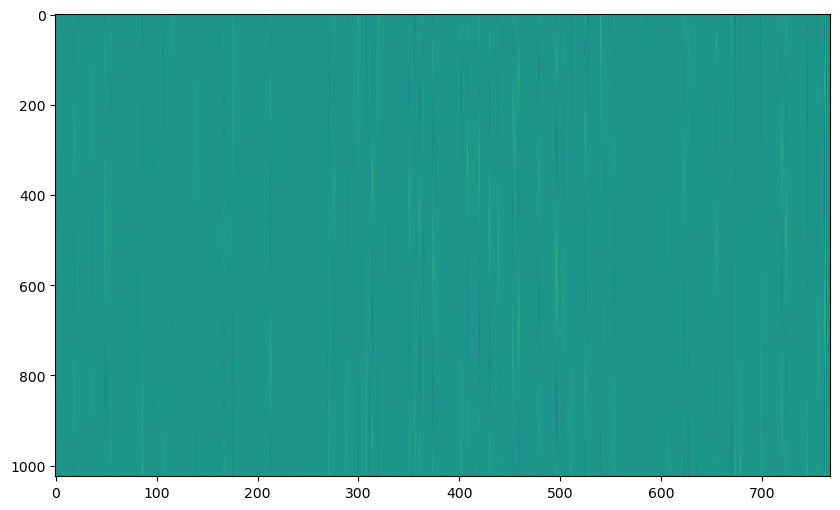

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.imshow(position_embeddings.detach().numpy(), aspect='auto')

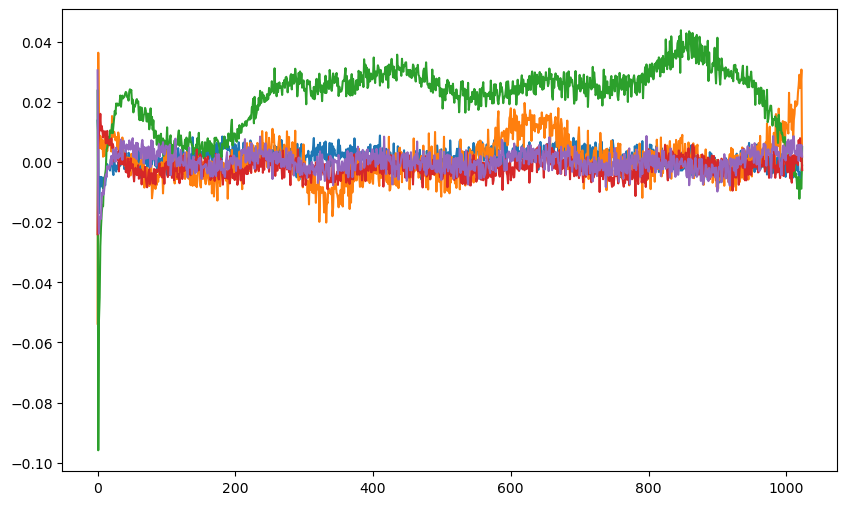

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(position_embeddings.detach().numpy()[:, 100])
plt.plot(position_embeddings.detach().numpy()[:, 200])
plt.plot(position_embeddings.detach().numpy()[:, 250])
plt.plot(position_embeddings.detach().numpy()[:, 400])
plt.plot(position_embeddings.detach().numpy()[:, 500])


In [8]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## Model Definition

Let's start defining the model layer by layer. Initially, we will create a model config that has all the hyper parameters for the model. 

In [9]:
@dataclass
class GPT2Config:
    vocab_size: int = 50257
    context_window_size: int = 1024
    embedding_dimension: int = 768
    num_layers: int = 12
    num_heads: int = 12
    dropout_embeddings: float = 0.1
    dropout_attention: float = 0.1
    dropout_residual: float = 0.1
    layer_norm_epsilon: float = 1e-5

Using the above config, let us define the GPT2 model skeleton:

In [10]:
class GPT2(nn.Module):
    def __init__(self, config: GPT2Config, device: str = 'cpu'):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config.vocab_size, config.embedding_dimension)
        self.positional_embedding = nn.Embedding(config.context_window_size, config.embedding_dimension)
        self.positional_ids = torch.arange(config.context_window_size).unsqueeze(0).to(device)
        self.embedding_dropout = nn.Dropout(config.dropout_embeddings)
        self.layers = nn.ModuleList([GPT2Layer(config) for _ in range(config.num_layers)])
        self.layer_norm = nn.LayerNorm(config.embedding_dimension)
        # gpt2 does not use a bias in the output layer
        self.output_layer = nn.Linear(config.embedding_dimension, config.vocab_size, bias=False)

    def forward(self, input_ids: torch.Tensor):
        _, current_sequence_length = input_ids.size()
        positions = self.positional_ids[:, :current_sequence_length]
        embeddings = self.token_embedding(input_ids) + self.positional_embedding(positions)
        embeddings = self.embedding_dropout(embeddings)
        for layer in self.layers:
            embeddings = layer(embeddings)
        embeddings = self.layer_norm(embeddings)
        return self.output_layer(embeddings)  # returns logits

The GPT2 model consists of token embeddings, positional embeddings, multiple GPT2 layers, layer normalization, and an output layer. GPT2 model takes input_ids as input and performs the following steps:
  - Embeds the input_ids using token embeddings and positional embeddings.
  - Applies dropout to regularize the embeddings before applying attention
  - Passes the embeddings through each GPT2 layer.
  - Applies layer normalization to the final embeddings.
  - Passes the normalized embeddings through the output layer to get logits.

We are still to define the GPT2Layer. Let's do that now

In [11]:
class GPT2Layer(nn.Module):
    def __init__(self, config: GPT2Config):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimension)
        # TODO: implement causal multi-head attention later
        self.attention = CausalMultiHeadAttention(config)
        self.dropout_attention = nn.Dropout(config.dropout_attention)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimension)
        # TODO: implement MLP later
        self.mlp = MLP(config)
        self.dropout_mlp = nn.Dropout(config.dropout_residual)

    def forward(self, embeddings: torch.Tensor):
        attention_output = embeddings + self.attention(self.layer_norm1(embeddings))
        mlp_output = attention_output + self.mlp(self.layer_norm2(attention_output))
        return mlp_output


In GPT2Layer, input embeddings are passed through a layer normalization layer, then through the self-attention mechanism, and finally through another layer normalization layer. 

The output of the self-attention mechanism is added to the input embeddings to form the attention_output as a residual connenction. The attention_output is then passed through another layer normalization layer and a multi-layer perceptron (MLP) to form the mlp_output. The mlp_output is then returned.

Let's define the MLP module first since that is the simpler of the two modules.


In [12]:
class MLP(nn.Module):
    def __init__(self, config: GPT2Config):
        super().__init__()
        self.fc1 = nn.Linear(config.embedding_dimension, 4 * config.embedding_dimension)
        # GPT2 uses the GELU activation function
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(4 * config.embedding_dimension, config.embedding_dimension)

    def forward(self, x: torch.Tensor):
        return self.fc2(self.activation(self.fc1(x)))

This is pretty straight-forward. It is a 2 layer MLP with a GELU activation in between. For more details on GELU, go to original paper - [GAUSSIAN ERROR LINEAR UNITS](https://arxiv.org/pdf/1606.08415v5).

Now, let's implement the final piece - `CausalMultiHeadAttention`. For attention calculation, we will use the flash attention implementation provided by pytorch.

In [13]:
class CausalMultiHeadAttention(nn.Module):
    def __init__(self, config: GPT2Config):
        super().__init__()
        self.num_heads = config.num_heads
        self.embedding_dimension = config.embedding_dimension
        self.head_dim = self.embedding_dimension // self.num_heads
        assert self.head_dim * self.num_heads == self.embedding_dimension, \
            "embedding_dimension must be divisible by num_heads"
        self.qkv = nn.Linear(self.embedding_dimension, 3 * self.embedding_dimension)
        self.out = nn.Linear(self.embedding_dimension, self.embedding_dimension)
        self.prob_dropout = config.dropout_attention 

    def forward(self, x: torch.Tensor):
        batch_size, sequence_length, _ = x.size()
        qkv = self.qkv(x)
        q, k, v = qkv.split(self.embedding_dimension, dim=2)  # split along the third dimension

        k = k.view(batch_size, sequence_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, sequence_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        q = q.view(batch_size, sequence_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        weights = F.scaled_dot_product_attention(q, k, v, is_causal=True, dropout_p=self.prob_dropout)
        output = weights.transpose(1, 2).contiguous().view(
            batch_size, sequence_length, self.embedding_dimension)
        output = self.out(output)
        return output

At this point, we should be at least be able to call the GPT2 model and get some output. The weights are randomly initialized so the output will be garbage, but we will tackle that later.

In [14]:
gpt2_model = GPT2(GPT2Config())
gpt2_out = gpt2_model(encoded_input['input_ids'])
print(gpt2_out.size())

torch.Size([1, 10, 50257])


Nice! so we are able to call the model e2e. Now starts the fun part. At this point, we should be able to take the weights from the huggingface model and apply them to the model we just defined.

Let's first print all the parameter keys and dimensions and match it against the huggingface model:

In [21]:
assert len(gpt2_model.state_dict().items()) == len(model.state_dict().items())

for (key, value), (ref_key, ref_value) in zip(gpt2_model.state_dict().items(), model.state_dict().items()):
    print(key, value.size(), "<>", ref_key, ref_value.size())

token_embedding.weight torch.Size([50257, 768]) <> transformer.wte.weight torch.Size([50257, 768])
positional_embedding.weight torch.Size([1024, 768]) <> transformer.wpe.weight torch.Size([1024, 768])
layers.0.layer_norm1.weight torch.Size([768]) <> transformer.h.0.ln_1.weight torch.Size([768])
layers.0.layer_norm1.bias torch.Size([768]) <> transformer.h.0.ln_1.bias torch.Size([768])
layers.0.attention.qkv.weight torch.Size([2304, 768]) <> transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
layers.0.attention.qkv.bias torch.Size([2304]) <> transformer.h.0.attn.c_attn.bias torch.Size([2304])
layers.0.attention.out.weight torch.Size([768, 768]) <> transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
layers.0.attention.out.bias torch.Size([768]) <> transformer.h.0.attn.c_proj.bias torch.Size([768])
layers.0.layer_norm2.weight torch.Size([768]) <> transformer.h.0.ln_2.weight torch.Size([768])
layers.0.layer_norm2.bias torch.Size([768]) <> transformer.h.0.ln_2.bias torch.Size([7

We can see that number of parameters and dimensions match. In some cases, we notice that the dimensions are transposed as [Andrej mentioned in his youtube video](https://www.youtube.com/watch?v=l8pRSuU81PU&t=2593s) as well. Let's write a method to load all the weights. 